In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import optuna
from optuna.samplers import TPESampler
from optuna.integration import TFKerasPruningCallback
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [3]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

X_full = train_df.drop('smoking', axis=1)
y_full = train_df['smoking']
X_test_final = test_df.copy()

print(f"Train: {train_df.shape}, Test: {test_df.shape}")
print(f"Class balance: {y_full.value_counts(normalize=True).to_dict()}")

Train: (38984, 23), Test: (16708, 22)
Class balance: {0: 0.6327211163554278, 1: 0.3672788836445721}


In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_full, y_full, test_size=0.15, random_state=RANDOM_STATE, stratify=y_full)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.18, random_state=RANDOM_STATE, stratify=y_train_val)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (27171, 22), Val: (5965, 22), Test: (5848, 22)


In [5]:
def create_health_features(df):
    df_new = df.copy()
    df_new['BMI'] = df_new['weight(kg)'] / ((df_new['height(cm)'] / 100) ** 2)
    df_new['waist_height_ratio'] = df_new['waist(cm)'] / df_new['height(cm)']
    df_new['total_hdl_ratio'] = df_new['Cholesterol'] / (df_new['HDL'] + 1)
    df_new['ldl_hdl_ratio'] = df_new['LDL'] / (df_new['HDL'] + 1)
    df_new['ast_alt_ratio'] = df_new['AST'] / (df_new['ALT'] + 1)
    df_new['pulse_pressure'] = df_new['systolic'] - df_new['relaxation']
    df_new['mean_bp'] = (df_new['systolic'] + 2 * df_new['relaxation']) / 3
    df_new['eyesight_avg'] = (df_new['eyesight(left)'] + df_new['eyesight(right)']) / 2
    df_new['eyesight_diff'] = np.abs(df_new['eyesight(left)'] - df_new['eyesight(right)'])
    df_new['hearing_avg'] = (df_new['hearing(left)'] + df_new['hearing(right)']) / 2
    df_new['age_squared'] = df_new['age'] ** 2
    return df_new

X_train_eng = create_health_features(X_train)
X_val_eng = create_health_features(X_val)
X_test_eng = create_health_features(X_test)
X_test_final_eng = create_health_features(X_test_final)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_val_scaled = scaler.transform(X_val_eng)
X_test_scaled = scaler.transform(X_test_eng)
X_test_final_scaled = scaler.transform(X_test_final_eng)

class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}

print(f"Features: {X_train_scaled.shape[1]}")
print(f"Class weights: {class_weights}")

Features: 33
Class weights: {0: np.float64(0.7902221963704048), 1: np.float64(1.3614089588135083)}


In [6]:
baseline_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = baseline_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=50, batch_size=64, class_weight=class_weights, callbacks=[early_stop], verbose=0)

y_val_pred_prob = baseline_model.predict(X_val_scaled, verbose=0).flatten()
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

print(f"Baseline Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Baseline F1: {f1_score(y_val, y_val_pred):.4f}")
print(f"Baseline ROC-AUC: {roc_auc_score(y_val, y_val_pred_prob):.4f}")

Baseline Accuracy: 0.7393
Baseline F1: 0.7051
Baseline ROC-AUC: 0.8368


In [7]:
def create_model(trial):
    n_layers = trial.suggest_int('n_layers', 2, 4)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    
    model = Sequential()
    first_units = trial.suggest_categorical('units_0', [64, 128, 256])
    model.add(Dense(first_units, activation='relu', input_dim=X_train_scaled.shape[1]))
    model.add(Dropout(trial.suggest_float('dropout_0', 0.1, 0.5)))
    
    for i in range(1, n_layers):
        units = trial.suggest_categorical(f'units_{i}', [32, 64, 128])
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(trial.suggest_float(f'dropout_{i}', 0.1, 0.5)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

def objective(trial):
    tf.keras.backend.clear_session()
    model = create_model(trial)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    early_stop = EarlyStopping(monitor='val_auc', patience=8, restore_best_weights=True, mode='max')
    pruning = TFKerasPruningCallback(trial, 'val_auc')
    
    history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=30, batch_size=batch_size, class_weight=class_weights, callbacks=[early_stop, pruning], verbose=0)
    return max(history.history['val_auc'])

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=10, show_progress_bar=True)

print(f"Best AUC: {study.best_value:.4f}")
print(f"Best params: {study.best_params}")

[I 2025-12-08 13:47:47,666] A new study created in memory with name: no-name-4a4792ac-07ab-496d-8ae8-f13f2b72c8b6


  0%|          | 0/10 [00:00<?, ?it/s]


[I 2025-12-08 13:48:52,664] Trial 0 finished with value: 0.8289670348167419 and parameters: {'n_layers': 3, 'learning_rate': 0.007969454818643935, 'optimizer': 'adam', 'units_0': 64, 'dropout_0': 0.4464704583099741, 'units_1': 64, 'dropout_1': 0.4879639408647978, 'units_2': 32, 'dropout_2': 0.17336180394137352, 'batch_size': 64}. Best is trial 0 with value: 0.8289670348167419.
[I 2025-12-08 13:49:19,612] Trial 1 finished with value: 0.8375592231750488 and parameters: {'n_layers': 2, 'learning_rate': 0.0016738085788752138, 'optimizer': 'rmsprop', 'units_0': 256, 'dropout_0': 0.1798695128633439, 'units_1': 64, 'dropout_1': 0.34301794076057535, 'batch_size': 128}. Best is trial 1 with value: 0.8375592231750488.
[I 2025-12-08 13:50:06,733] Trial 2 finished with value: 0.8319340348243713 and parameters: {'n_layers': 4, 'learning_rate': 0.004138040112561018, 'optimizer': 'adam', 'units_0': 64, 'dropout_0': 0.29807076404450805, 'units_1': 64, 'dropout_1': 0.36500891374159283, 'units_2': 128,

In [8]:
tf.keras.backend.clear_session()
best_trial = study.best_trial
final_model = create_model(best_trial)

early_stop = EarlyStopping(monitor='val_auc', patience=15, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)

X_train_full = np.vstack([X_train_scaled, X_val_scaled])
y_train_full = np.concatenate([y_train, y_val])

history = final_model.fit(X_train_full, y_train_full, validation_data=(X_test_scaled, y_test), epochs=100, batch_size=best_trial.params['batch_size'], class_weight=class_weights, callbacks=[early_stop, reduce_lr], verbose=0)

print("Final model trained")

Final model trained


In [9]:
y_test_pred_prob = final_model.predict(X_test_scaled, verbose=0).flatten()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_pred_prob):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Non-Smoker', 'Smoker']))

Accuracy:  0.7426
Precision: 0.6087
Recall:    0.8380
F1-Score:  0.7052
ROC-AUC:   0.8421

Confusion Matrix:
[[2543 1157]
 [ 348 1800]]

Classification Report:
              precision    recall  f1-score   support

  Non-Smoker       0.88      0.69      0.77      3700
      Smoker       0.61      0.84      0.71      2148

    accuracy                           0.74      5848
   macro avg       0.74      0.76      0.74      5848
weighted avg       0.78      0.74      0.75      5848



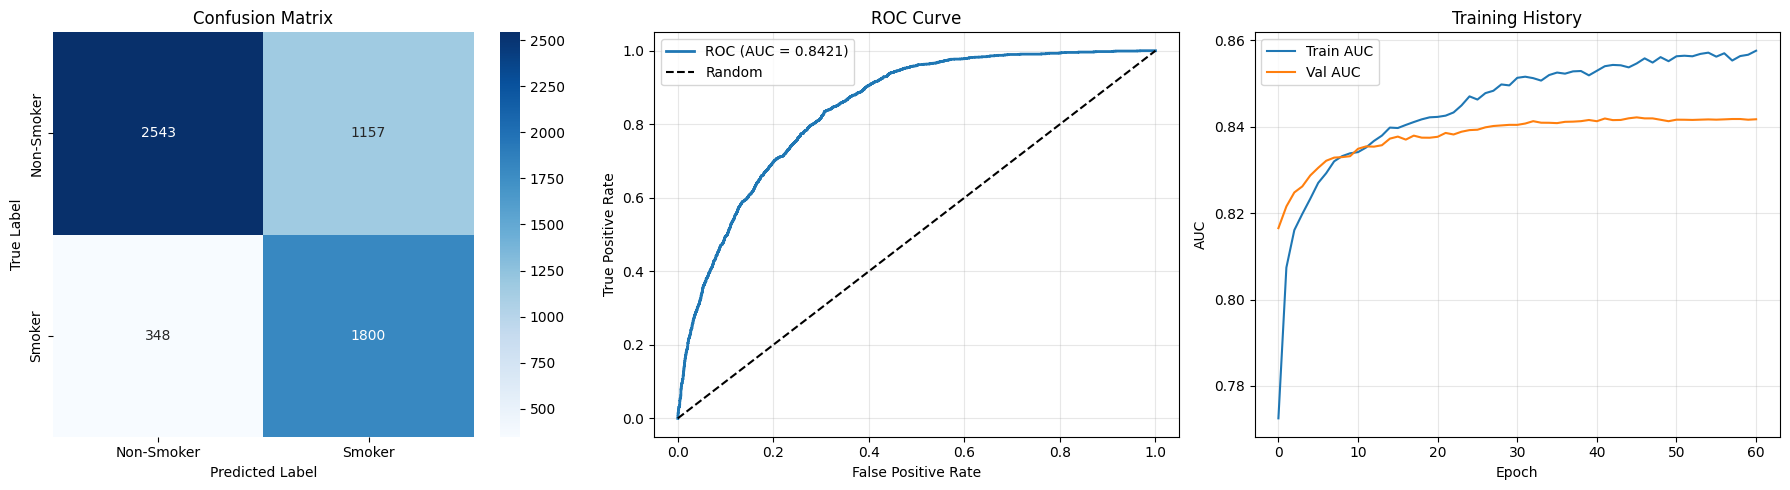

In [10]:
cm = confusion_matrix(y_test, y_test_pred)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'], ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
axes[1].plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_test_pred_prob):.4f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].plot(history.history['auc'], label='Train AUC')
axes[2].plot(history.history['val_auc'], label='Val AUC')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('Training History')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()